# Loading data from CNF 


Set to true if the notebook is on google colab

In [12]:
colab_notebook = False

### Import libraries

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
if colab_notebook:
    %pip install torchdiffeq
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.datasets import ImageFolder
import os, glob, random, shutil
from PIL import Image
import math
from torch.utils.data import Subset
from tqdm.auto import tqdm
import torch.optim as optim
import os
import numpy as np
from torchdiffeq import odeint_adjoint as odeint
import torchvision.transforms as transforms

## Defining a simple network

In [14]:
# The RHS of the ODE du/dt=f(u(t)):
class RHSFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, 128)
        self.fc2 = nn.Linear(128,dim)
        self.tanh = nn.Tanh()

    def forward(self, t, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        return x


# The ODE, i.e., CNF model:
class CNFModel(nn.Module):
    def __init__(self, dim, T=1):
        super().__init__()
        self.T = T
        self.dim = dim
        self.f = RHSFunc(dim)
        self.base_dist = torch.distributions.Normal(torch.zeros(dim), torch.ones(dim)) # Normal distribution with mean 0 and std 1
        self.integration_time = torch.tensor([T, 0]).float()
        
    def forward(self, x):
        """
        The model takes a batch x of our data. x has some distribution that we
        would like to learn. Below, x is transformed into z0, which is a sample
        of our base distribution N(0,1). We integrate backwards since z0 is a
        sample in the "original" distribution.
        Note that df/dz0 is set to zero, so the RHS of eq. (6) in 
        https://arxiv.org/pdf/1806.07366 becocomes log(p(x))=log(p(z0)), meaning
        that the model is not accounting for the volume change in the likelihood
        computation. While this is not entirely accurate, the network is still 
        learning a vector field f describing where samples z0 in the latent 
        space end up, yielding positive results in the end.
        """
        z0 = odeint(self.f, x, self.integration_time)[-1] # Integrating over f from 1 to 0
        return z0

    def log_prob(self, x):
        z0 = self.forward(x)
        return self.base_dist.log_prob(z0).sum(dim=1)


In [15]:
# Find all .pth files
pth_files = glob.glob(os.path.join("*.pth"))

if not pth_files:
    print("No .pth files found.")
    exit()
    
else:
    print("The following .pth files are in the folder:")
    for i, f in enumerate(pth_files):
        print(f"{i+1}. {os.path.basename(f)}")

    choice = int(input("Pick one by typing its number: "))
    file_to_load = pth_files[choice-1]

    print(f"\nLoading {file_to_load}...")



    # Load checkpoint
    checkpoint = torch.load(file_to_load)

    losses = checkpoint["losses"]
    saved_models = checkpoint["saved_models"]





The following .pth files are in the folder:
1. model_state_7_CNF.pth
Pick one by typing its number: 1

Loading model_state_7_CNF.pth...


In [17]:
choice_2 = input(f"{len(saved_models)} epochs were saved in {file_to_load}. Do you want to recover one of them (yes/no)?")
if choice_2 == 'yes':
    choice_3 = int(input(f"Pick an epoch"))
    picked_epoch, picked_state_dict = saved_models[choice_3-1]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dim = 28*28
    
    model = CNFModel(dim).to(device)
    model.load_state_dict(picked_state_dict)
    model.eval()
    
    print(f"Restored model from epoch {choice_3}")
    
if choice_2 == 'no':
    print("No model was recovered.")
if choice_2 != 'yes' and choice_2 != 'no':
    print("Invalid input.")

100 epochs were saved in model_state_7_CNF.pth. Do you want to recover one of them (yes/no)?yes
Pick an epoch100
Restored model from epoch 100


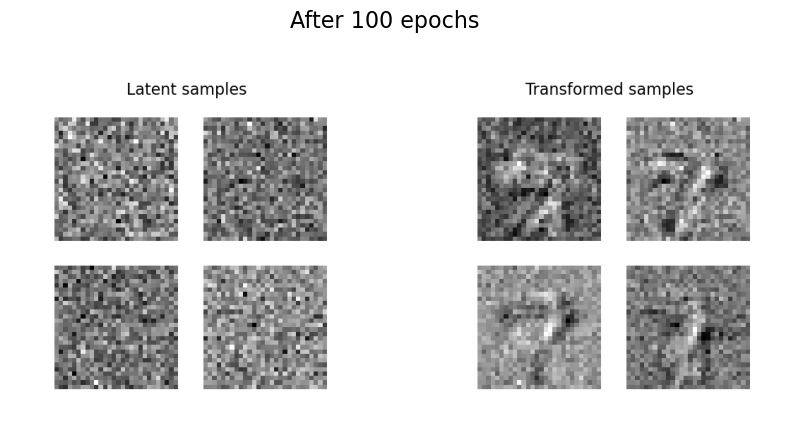

In [18]:
if choice_2 == 'yes':
    with torch.no_grad():
        z0 = torch.randn(4, dim).to(device) # Random latent samples
        z1 = odeint(model.f, z0, torch.tensor([0.0, model.T]))[-1] # Integrating over the learned vector field f from 0 to T=1 to get z(1)=z1. Initial condition z(0)=z0.
        z1 = z1.view(-1, 1, 28, 28) # Reshape to images of shape (1, 28, 28).
        
    fig1, axs1 = plt.subplots(2, 2, figsize=(5,5))
        
        
    for i, ax in enumerate(axs1.flatten()):
        z0_new = z0.view(-1, 1, 28, 28)
        ax.imshow(z0_new[i,0], cmap='gray')
        ax.axis('off')
    fig1.suptitle('Latent samples', fontsize=16)
        
    plt.close(fig1)
        
        
    fig2, axs2 = plt.subplots(2, 2, figsize=(5,5))

        
    for i, ax in enumerate(axs2.flatten()):
        ax.imshow(z1[i,0], cmap='gray')
        ax.axis('off')
            
    fig2.suptitle('Transformed samples', fontsize=16)
    plt.close(fig2)


    fig1.canvas.draw() # Figure gets rendered
    w1, h1 = fig1.canvas.get_width_height() # Get width and height in number of pixels
    img1 = fig1.canvas.tostring_rgb() # Get a a bytestring of RGB values
    img1 = np.frombuffer(img1, dtype=np.uint8) # Turn the bytestring into a 1D Numpy array of type uint8
    img1 = img1.reshape(h1, w1, 3)   # Reshape the 1D Numpy array 
        

    fig2.canvas.draw()
    w2, h2 = fig2.canvas.get_width_height()
    img2 = np.frombuffer(fig2.canvas.tostring_rgb(), dtype=np.uint8)
    img2 = img2.reshape(h2, w2, 3)

    fig_comb, axs_comb = plt.subplots(1, 2, figsize=(10, 5)) # I'll now plot them side by side
        
        
    axs_comb[0].imshow(img1)
    axs_comb[0].axis("off")
    axs_comb[1].imshow(img2)
    axs_comb[1].axis("off")
    
    epoch = choice_3-1
    if epoch+1 == 1:
                            
        fig_comb.suptitle(f'After {epoch+1} epoch', fontsize=16)
    else:
        fig_comb.suptitle(f'After {epoch+1} epochs', fontsize=16)
    plt.show()

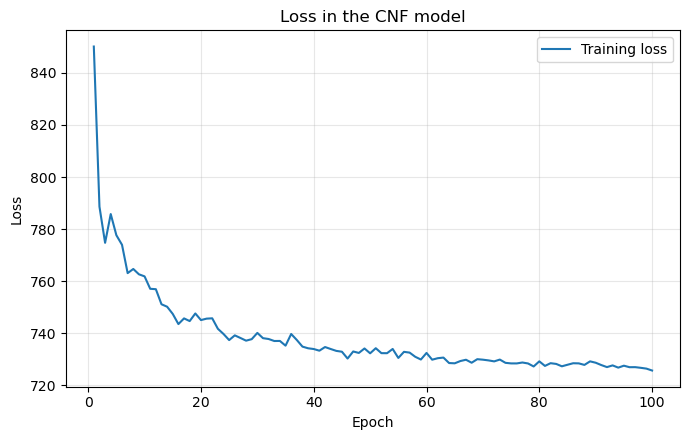

In [22]:
epochs, vals = zip(*losses)
epochs = np.array(epochs)
vals = np.array(vals)

plt.figure(figsize=(7, 4.5))
plt.plot(epochs, vals, label="Training loss")


plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss in the CNF model")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()